# Food Image Classifier

This part of the Manning Live project - https://liveproject.manning.com/project/210 . In synposis, By working on this project, I will be classying the food variety of 101 type. Dataset is already availble in public but we will be starting with subset of the classifier

## Dataset

As a general best practice to ALWAYS start with a subset of the dataset rather than a full one. There are two reason for the same
1. As you experiement with the model, You dont want to run over all the dataset that will slow down the process
2. You will end up wasting lots of GPU resources well before the getting best model for the Job

In the Case live Project, The authors already shared the subset of the notebook so we can use the same for the baseline model

In [1]:
#!wget https://lp-prod-resources.s3-us-west-2.amazonaws.com/other/Deploying+a+Deep+Learning+Model+on+Web+and+Mobile+Applications+Using+TensorFlow/Food+101+-+Data+Subset.zip
#!unzip Food+101+-+Data+Subset.zip

--2021-05-06 13:17:24--  https://lp-prod-resources.s3-us-west-2.amazonaws.com/other/Deploying+a+Deep+Learning+Model+on+Web+and+Mobile+Applications+Using+TensorFlow/Food+101+-+Data+Subset.zip
Resolving lp-prod-resources.s3-us-west-2.amazonaws.com (lp-prod-resources.s3-us-west-2.amazonaws.com)... 52.218.181.89
Connecting to lp-prod-resources.s3-us-west-2.amazonaws.com (lp-prod-resources.s3-us-west-2.amazonaws.com)|52.218.181.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153668842 (147M) [application/zip]
Saving to: ‘Food+101+-+Data+Subset.zip’

Food+101+-+Data+Sub 100%[===================>] 146.55M  12.4MB/s    in 14s     

2021-05-06 13:17:38 (10.8 MB/s) - ‘Food+101+-+Data+Subset.zip’ saved [153668842/153668842]



In [94]:
import torch
from torchvision import datasets,models
import torchvision.transforms as tt
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader,random_split,Dataset
import torch.nn as NN
import torch.nn.functional as F
import torch.optim as optim

In [95]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(224, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(),
                         tt.Resize(224),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize([224,224]),tt.ToTensor(), tt.Normalize(*stats)])

Create a Pytorch dataset from the image folder. This will allow us to create a Training dataset and validation dataset

In [96]:
ds = datasets.ImageFolder('food-101-subset/images/')

In [97]:
class CustomDataset(Dataset):
    def __init__(self,ds,transformer):
        self.ds = ds
        self.transform = transformer
    
    def __getitem__(self,idx):
        image,label = self.ds[idx]
        img = self.transform(image)
        return img,label
    
    def __len__(self):
        return len(ds)

In [98]:
train_len=0.8*len(ds)
val_len = len(ds) - train_len
int(train_len),int(val_len)

(2400, 600)

In [99]:
train_ds,val_ds = random_split(dataset=ds,lengths=[int(train_len),int(val_len)],generator=torch.Generator().manual_seed(42))

In [100]:
t_ds = CustomDataset(train_ds.dataset,train_tfms)
v_ds = CustomDataset(val_ds.dataset,valid_tfms)

In [102]:
batch_size = 64
train_dl = DataLoader(t_ds, batch_size, shuffle=True, pin_memory=True)
valid_dl = DataLoader(v_ds, batch_size*2, pin_memory=True)

In [103]:
for x,yb in valid_dl:
    print(x.shape)
    break;

torch.Size([128, 3, 224, 224])


In [104]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


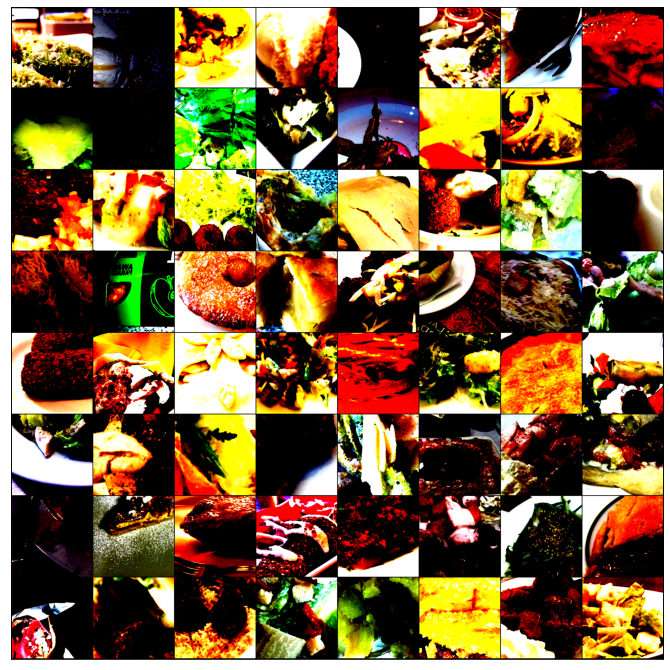

In [105]:
show_batch(train_dl)

In [106]:
model = models.resnet50(pretrained=True)

In [107]:
num_of_features = model.fc.in_features
model.fc = NN.Linear(num_of_features,3)
criterion = NN.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [108]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [109]:
model = model.to(device)

In [110]:
from fastprogress.fastprogress import master_bar, progress_bar

In [111]:
def fit(epochs,model,train_dl,valid_dl,loss_fn,opt):
    mb = master_bar(range(epochs))
    mb.write(['epoch','train_loss','valid_loss','trn_acc','val_acc'],table=True)

    for i in mb:    
        trn_loss,val_loss = 0.0,0.0
        trn_acc,val_acc = 0,0
        trn_n,val_n = len(train_dl.dataset),len(valid_dl.dataset)
        model.train()
        for xb,yb in progress_bar(train_dl,parent=mb):
            xb,yb = xb.to(device), yb.to(device)
            out = model(xb)
            opt.zero_grad()
            loss = loss_fn(out,yb)
            _,pred = torch.max(out.data, 1)
            trn_acc += (pred == yb).sum().item()
            trn_loss += loss.item()
            loss.backward()
            opt.step()
        trn_loss /= mb.child.total
        trn_acc /= trn_n

        model.eval()
        with torch.no_grad():
            for xb,yb in progress_bar(valid_dl,parent=mb):
                xb,yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = loss_fn(out,yb)
                val_loss += loss.item()
                _,pred = torch.max(out.data, 1)
                val_acc += (pred == yb).sum().item()
        val_loss /= mb.child.total
        val_acc /= val_n

        mb.write([i,f'{trn_loss:.6f}',f'{val_loss:.6f}',f'{trn_acc:.6f}',f'{val_acc:.6f}'],table=True)

In [113]:
fit(10,model=model,train_dl=train_dl,valid_dl=valid_dl,loss_fn=criterion,opt=optimizer_ft)

epoch,train_loss,valid_loss,trn_acc,val_acc
0,0.398077,0.378294,0.850667,0.840000
1,0.291343,0.258515,0.893333,0.900333
2,0.247000,0.196674,0.907333,0.932333
3,0.236486,0.182146,0.914667,0.933667
4,0.198635,0.160825,0.926333,0.940000
5,0.180658,0.151620,0.932667,0.947333
6,0.163593,0.137755,0.937667,0.953333
7,0.151831,0.171987,0.940000,0.936667
8,0.146026,0.181687,0.946667,0.930000
9,0.134499,0.123069,0.952333,0.955333


In [108]:
torch.save(model.state_dict,'baseline.pth')